# IS460-G2 Machine Learning & Applications

## Project Topic: Classification and Prediction of Pneumonia from Chest X-Ray Images

### Naive Bayes Implementation

#### Group 7: Shaun, Shan Mei, Xiao Xiao, Xiao Fang, Matthew, Tun Hao
 
 Following the Severe Pneumonia clusters that raised questions on accuracy and precision of pneumonia diagnosis during the COVID pandemic, this project aims to accurately identify and diagnose pneumonia patients through image classification and explore other methods of building machine learning algorithms to solve the problem.
 
(https://www.straitstimes.com/singapore/health/all-pneumonia-patients-in-public-hospitals-here-being-tested-for-coronavirus-moh) 

### Install Packages

In [1]:
# # Run Once
# !pip install opencv-python
# !pip install tensorflow
# !pip install --upgrade scikit-image
# !pip install numpy scikit-learn

# import skimage
# print(skimage.__version__)

### Import Packages

In [22]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import keras 
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

from skimage.feature.texture import graycomatrix, graycoprops
from scipy.stats import skew, kurtosis

### Import Dataset

In [3]:
path = "chest_xray"
folders = ['train','test','val']

pd.DataFrame(os.listdir(path),columns=['Files'])

,Files
0,chest_xray
1,test
2,train
3,val
4,__MACOSX


In [4]:
# View Image Count in Folders
dict_={'train':[],'test':[],'val':[]}
for i in tqdm(folders):
    path_=os.path.join(path,i)
    for j in os.listdir(path_):
        dict_[i].append(len(os.listdir(os.path.join(path_,j))))
pd.DataFrame(dict_,index=os.listdir(path_))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.20it/s]


,train,test,val
NORMAL,1341,234,8
PNEUMONIA,3875,390,8


In [5]:
# Define Function to Identify Image Sizes
def Size(folder):
    size=[]
    path_=os.path.join(path,folder)
    for i in tqdm(os.listdir(path_)):
        path2=os.path.join(path_,i)
        for j in os.listdir(path2):
            img=cv2.imread(os.path.join(path2,j))
            size.append(img.shape)
    return pd.Series(size)

In [6]:
# View Image Sizes in Each Folder
print("Size of train: ", Size('train')); print("Size of test: ", Size('test')); print("Size of val: ",Size('val'))

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:03<00:00, 61.60s/it]


Size of train:  0       (1858, 2090, 3)
1       (1152, 1422, 3)
2       (1434, 1810, 3)
3       (1279, 1618, 3)
4       (1125, 1600, 3)
             ...       
5211     (882, 1414, 3)
5212     (696, 1256, 3)
5213     (856, 1152, 3)
5214     (728, 1248, 3)
5215     (784, 1176, 3)
Length: 5216, dtype: object


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:14<00:00,  7.11s/it]


Size of test:  0      (1317, 1857, 3)
1      (1509, 2111, 3)
2      (1837, 2031, 3)
3      (1326, 1663, 3)
4      (1818, 2053, 3)
            ...       
619     (856, 1120, 3)
620     (856, 1064, 3)
621    (1024, 1400, 3)
622    (1016, 1264, 3)
623    (1122, 1704, 3)
Length: 624, dtype: object


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]

Size of val:  0     (1416, 1776, 3)
1     (1040, 1272, 3)
2     (1416, 1736, 3)
3      (928, 1288, 3)
4     (1104, 1240, 3)
5     (1104, 1328, 3)
6     (1225, 1632, 3)
7     (1302, 1564, 3)
8       (592, 968, 3)
9      (712, 1072, 3)
10     (664, 1152, 3)
11     (944, 1416, 3)
12     (864, 1256, 3)
13     (656, 1016, 3)
14     (952, 1192, 3)
15    (1128, 1664, 3)
dtype: object


### Data Pre-Processing

In our Image Classification problem, Data Pre-Processing involves:  
  
- Rescaling Colors in Images 
- Resiziing Images
- Normalizing Pixel Values

In [7]:
# Pre-Process Dataset
Size=80
images=[]
labels=[]

def load():
    global images
    global labels
    
    for folder in tqdm(folders):
        path_=os.path.join(path,folder)
        
        for files in os.listdir(path_):
            path2=os.path.join(path_,files)
            
            for img in os.listdir(path2):
                # Read Images
                image=cv2.imread(os.path.join(path2,img))
                # Convert BGR to RGB Color Codes
                image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                # Resize Images
                image=cv2.resize(image,(Size,Size))
                # Normalize Pixel Values (Scaling to [0, 1])
                image=image/255.0
                images.append(image)
                labels.append(files)      
load()

images=np.array(images)
labels=np.array(labels)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:11<00:00, 23.67s/it]


In [8]:
# Overview of Pre-Processed Data
print('Images Shape :',images.shape); print('Labels Shape :',labels.shape)

Images Shape : (5856, 80, 80, 3)
Labels Shape : (5856,)


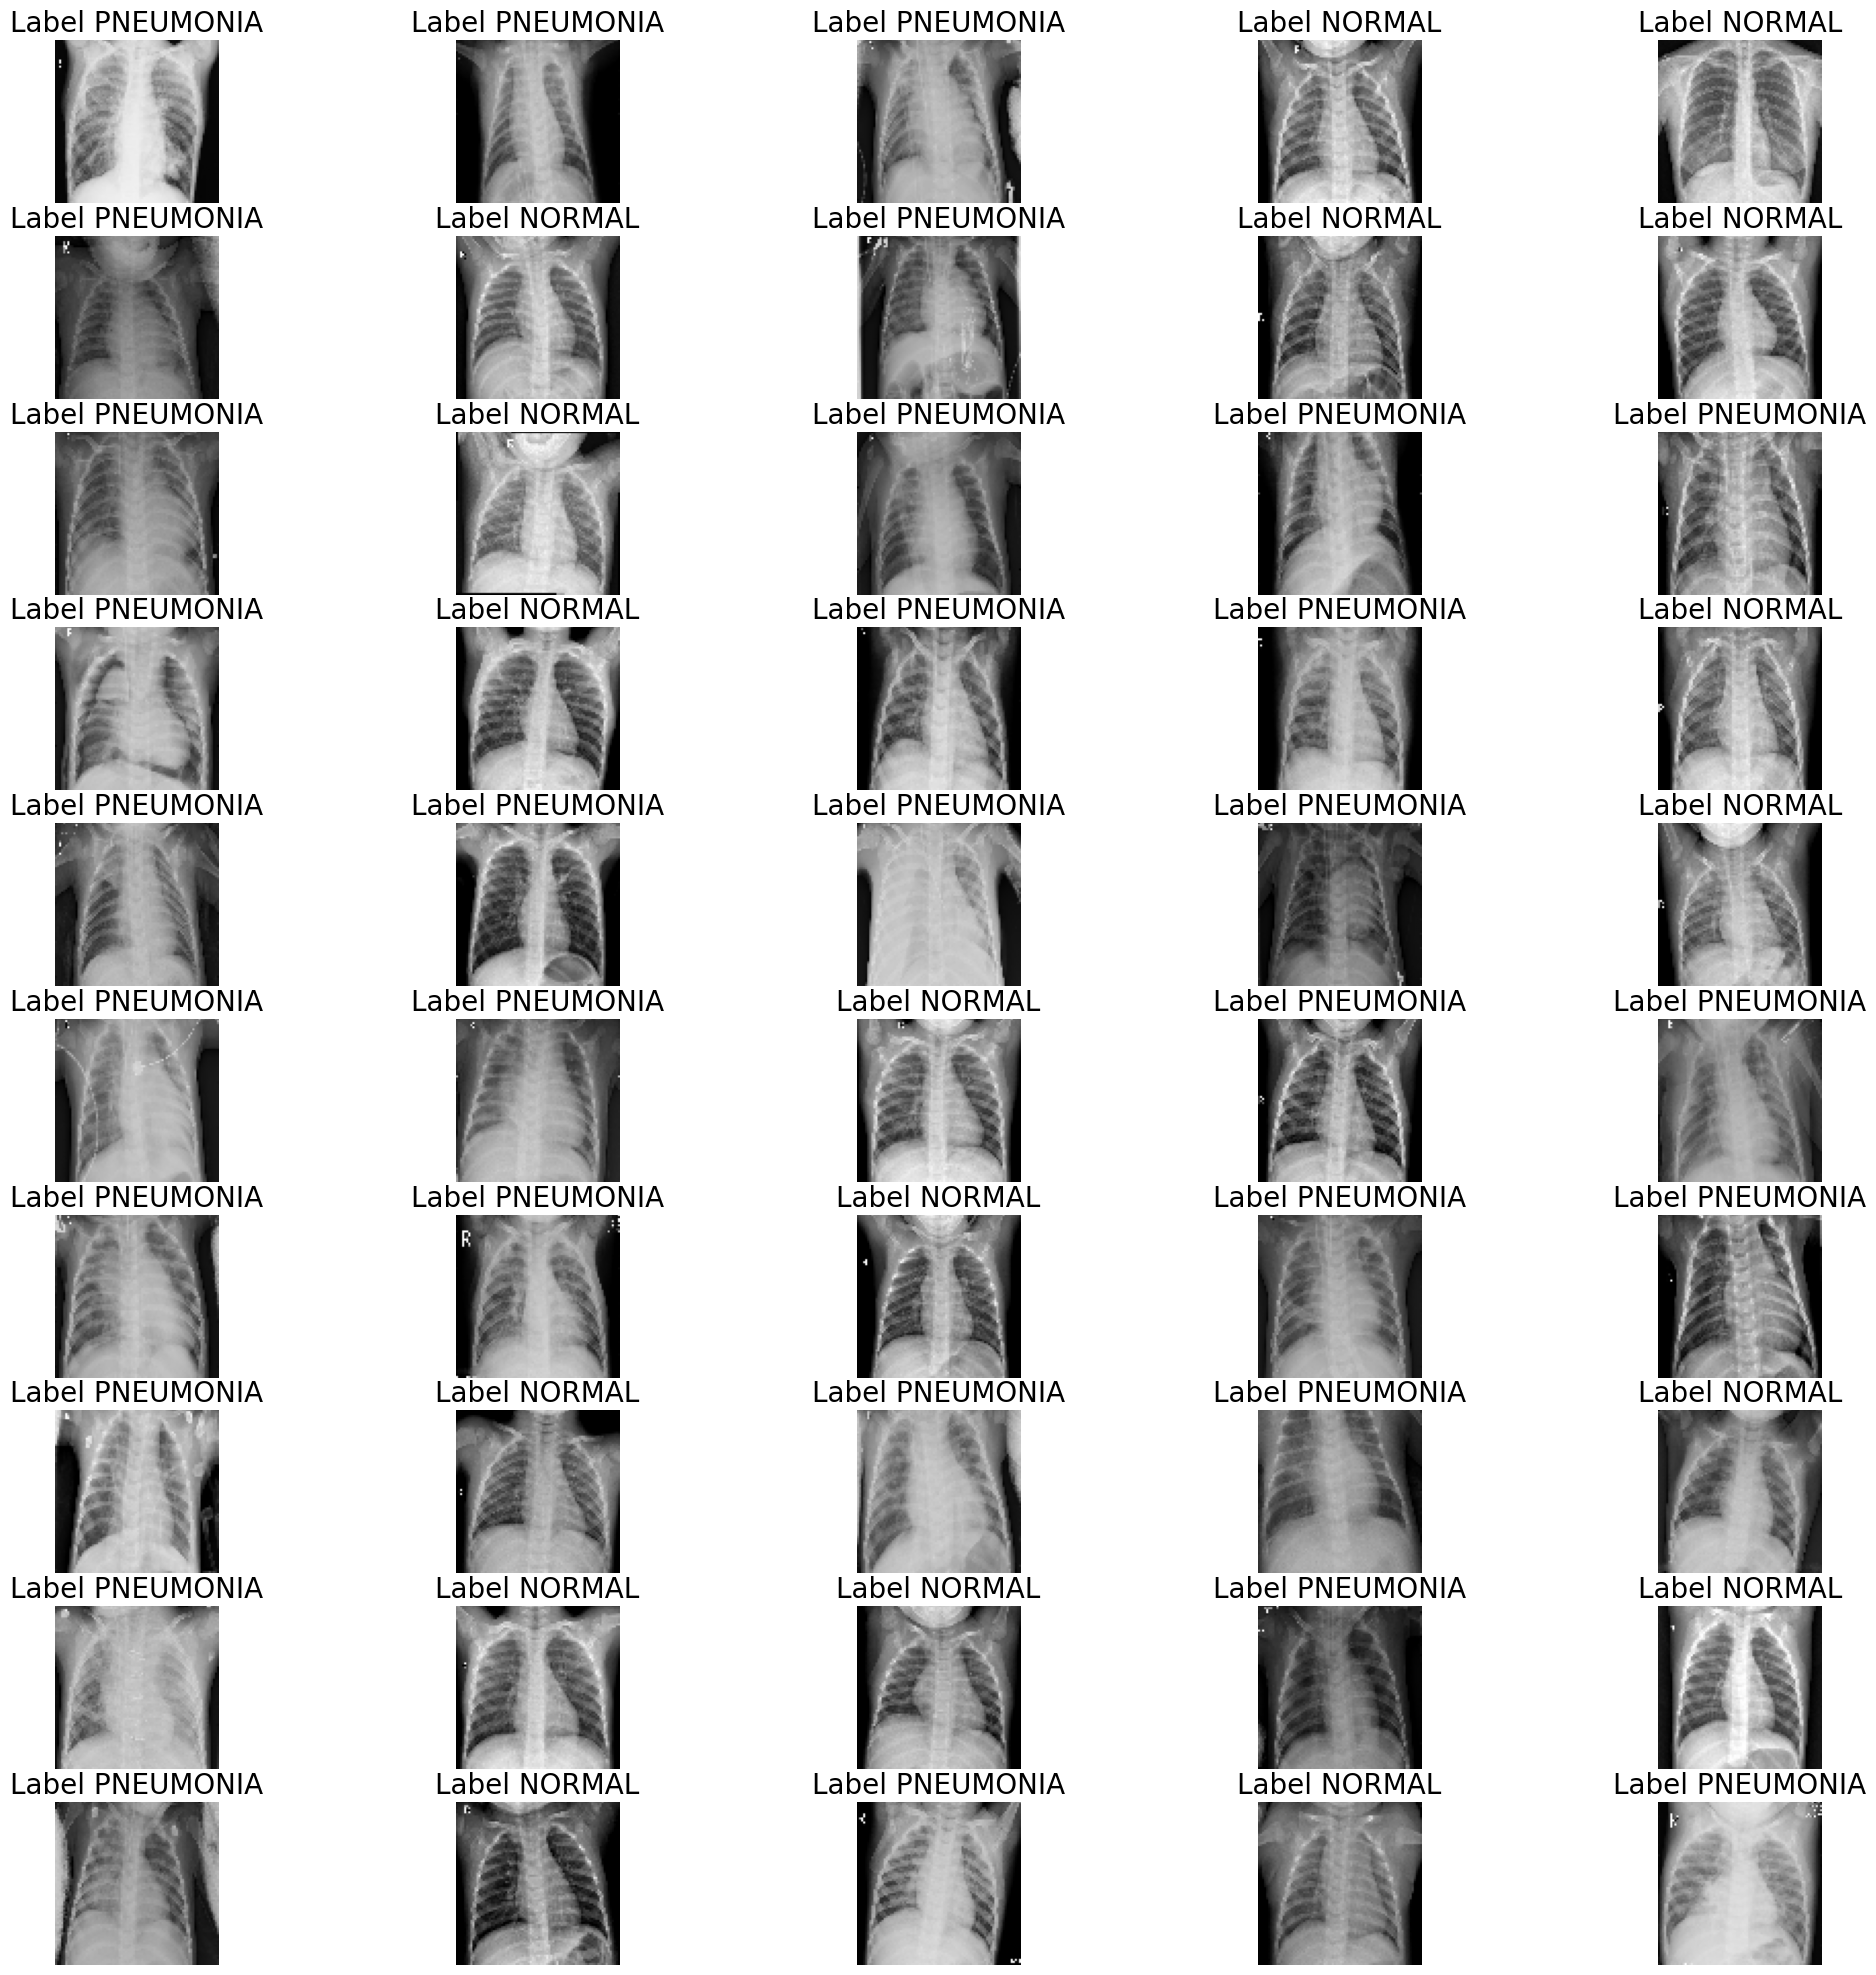

In [9]:
# Plot Pre-Processed Data
plt.figure(figsize=(25,25))
x = 1
for i in np.random.randint(0,len(images),50):
    plt.subplot(10, 5, x)
    plt.imshow(images[i])
    plt.title(f'Label {labels[i]}', fontsize=20)
    plt.axis('off')    
    x += 1

### Feature Extraction

To build a Naive Bayes Model in this problem, we will need to create numerical features based off these images. In this method, we assume grayscale images _(8-bit range)_ because they are widely used for texture analysis and basic feature extraction in image processing and computer vision. 

Considering that our dataset are X-Ray Images of Lungs, we build a pandas DataFrame with the following features from these images:  
- Histogram of Pixel Intensities - Represents distribution of pixel intensities in the image  
- Texture Features (Gray-Level Co-Occurence Matrix) - Measures texture patterns in the X-Ray image  
- Statistical Features - Compute statistics such as mean, standard deviation, skewness, and kurtosis of pixel intensities

#### Histogram of Pixel Intensities

In [10]:
intensity_histograms = []

for image in images:
    
    # Convert the image data type to uint8
    image = (image * 255).astype(np.uint8)
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate Histogram of Pixel Intensities
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist.flatten()
    
    # Append intensity histogram features to the list
    intensity_histograms.append(hist)
    
# Create Pandas DataFrame with intensity histogram features
nb_histogram = pd.DataFrame(intensity_histograms)

print(nb_histogram.head())

     0     1     2     3     4     5     6     7     8     9    ...  246  247  \
0   32.0   4.0   4.0   3.0  11.0   7.0  12.0  14.0  21.0  23.0  ...  0.0  1.0   
1  475.0  14.0  14.0  12.0  18.0  16.0  12.0  14.0  16.0  15.0  ...  0.0  1.0   
2  700.0  59.0  34.0  30.0  24.0  29.0  11.0  10.0   2.0   2.0  ...  0.0  0.0   
3   72.0  24.0  20.0  16.0  31.0  31.0  30.0  34.0  28.0  33.0  ...  1.0  0.0   
4  748.0  24.0  20.0  15.0  16.0  18.0  18.0   8.0  13.0  12.0  ...  0.0  1.0   

   248  249  250  251  252  253  254  255  
0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  2.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  
2  0.0  1.0  0.0  1.0  0.0  3.0  0.0  1.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  4.0  
4  0.0  1.0  0.0  0.0  1.0  0.0  1.0  4.0  

[5 rows x 256 columns]


#### Texture Features (Gray-Level Co-Occurence Matrix)

In [11]:
glcm_contrast = []
glcm_correlation = []

for image in images:
    
    # Convert the image data type to uint8
    image = (image * 255).astype(np.uint8)
    
    # Convert the color image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate GLCM
    glcm = graycomatrix(gray_image, [1], [0], symmetric=True, normed=True)

    # Calculate GLCM features (contrast and correlation)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    # Append GLCM features and label to respective lists
    glcm_contrast.append(contrast)
    glcm_correlation.append(correlation)

# Create a Pandas DataFrame with GLCM features and labels
import pandas as pd

nb_glcm = pd.DataFrame({'GLCM_Contrast': glcm_contrast, 'GLCM_Correlation': glcm_correlation})

print(nb_glcm)

      GLCM_Contrast  GLCM_Correlation
0        390.416139          0.948514
1        499.194620          0.928829
2        358.495253          0.960998
3        325.409335          0.960163
4        625.791139          0.924702
...             ...               ...
5851     522.671994          0.920236
5852     449.555063          0.929513
5853     308.528165          0.946911
5854     239.602215          0.958970
5855     338.477848          0.970692

[5856 rows x 2 columns]


#### Statistical Features

In [12]:
# Statistical Features
means = []
stds = []
skewnesses = []
kurtoses = []

for image in images:
    
    # Convert the image data type to uint8
    image = (image * 255).astype(np.uint8)
    
    # Calculate statistics of pixel intensities
    mean = np.mean(image)
    std = np.std(image)
    skewness = np.mean(((image - mean) / std) ** 3)
    kurtosis = np.mean(((image - mean) / std) ** 4)

    # Append statistical features and label to respective lists
    means.append(mean)
    stds.append(std)
    skewnesses.append(skewness)
    kurtoses.append(kurtosis)

# Create a Pandas DataFrame with statistical features and labels
import pandas as pd

nb_stat = pd.DataFrame({'Mean': means, 'Std': stds, 'Skewness': skewnesses, 'Kurtosis': kurtoses})

print(nb_stat)

            Mean        Std  Skewness  Kurtosis
0     128.727031  62.232021 -0.453478  2.199526
1     100.611094  59.884171 -0.034412  2.012165
2     121.801563  68.709242 -0.472228  2.060992
3     132.965156  64.893443 -0.680736  2.334244
4     106.217656  65.075876 -0.219956  1.910755
...          ...        ...       ...       ...
5851  127.570156  58.539429 -0.817112  2.673775
5852  141.617344  58.213894 -0.812905  2.997958
5853  140.622187  54.653383 -1.220892  3.424876
5854  142.912344  55.179332 -1.202057  3.590882
5855  105.937500  76.446802 -0.261048  1.527899

[5856 rows x 4 columns]


#### Concatenate Numerical Features with Label

In [13]:
data_nb = pd.concat([nb_stat, nb_glcm, nb_histogram], axis=1)
data_nb['Label'] = labels

print(data_nb.columns.tolist()); print(data_nb.dtypes)

['Mean', 'Std', 'Skewness', 'Kurtosis', 'GLCM_Contrast', 'GLCM_Correlation', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206

### Dimensionality Reduction

Among the numerical features created, Column Names '0', '1'...'255' represent the Histogram of Pixel Intensities. This causes our dataset to be extremely high in dimensionality. Before conducting analysis and modelling, we attempt to reduce dimensionality by converting histogram features to features that can justify the shape of this histogram - "Hist_Skewness", "Hist_Kurtosis".

In [19]:
data_nb[1]

0         4.0
1        14.0
2        59.0
3        24.0
4        24.0
        ...  
5851    221.0
5852    159.0
5853      9.0
5854     50.0
5855     32.0
Name: 1, Length: 5856, dtype: float32

In [23]:
histogram_features = range(256)

# Obtain Skewness of Histogram Features
data_nb['Hist_Skewness'] = data_nb[histogram_features].apply(lambda row: skew(row), axis=1)

# Obtain Kurtosis of Histogram Features
data_nb['Hist_Kurtosis'] = data_nb[histogram_features].apply(lambda row: kurtosis(row), axis=1)

# Drop Initial Histogram Features
data_nb = data_nb.drop(columns=histogram_features)

In [24]:
# Label Encode the Target "Label"
label_encoder = LabelEncoder()

# Fit & Transform "Label"
y_encoded = label_encoder.fit_transform(data_nb['Label'])

# View mappings of encoded Labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Label Mapping: ")

for label, code in label_mapping.items():
    print(f"{label}: {code}")
    
# Fit Labelling into dataframe
data_nb["Label"] = y_encoded

data_nb

Label Mapping: 
NORMAL: 0
PNEUMONIA: 1


,Mean,Std,Skewness,Kurtosis,GLCM_Contrast,GLCM_Correlation,Label,Hist_Skewness,Hist_Kurtosis
0,128.727031,62.232021,-0.453478,2.199526,390.416139,0.948514,0,-0.069868,-1.211845
1,100.611094,59.884171,-0.034412,2.012165,499.194620,0.928829,0,11.886041,170.417474
2,121.801563,68.709242,-0.472228,2.060992,358.495253,0.960998,0,13.268825,196.696651
3,132.965156,64.893443,-0.680736,2.334244,325.409335,0.960163,0,0.534510,-0.462836
4,106.217656,65.075876,-0.219956,1.910755,625.791139,0.924702,0,14.198189,215.678237
...,...,...,...,...,...,...,...,...,...
5851,127.570156,58.539429,-0.817112,2.673775,522.671994,0.920236,1,2.649250,13.601179
5852,141.617344,58.213894,-0.812905,2.997958,449.555063,0.929513,1,1.224176,5.789750
5853,140.622187,54.653383,-1.220892,3.424876,308.528165,0.946911,1,1.608228,1.859598
5854,142.912344,55.179332,-1.202057,3.590882,239.602215,0.958970,1,2.252195,7.182391


### Implementation of Gaussian Naive Bayes

To begin the Modelling, we split our data into Training, Validation and Test sets.

In [25]:
# Define Input and Output Variables
X = data_nb.drop(columns='Label', axis=1)
y = data_nb['Label']

# Initial Train-Test Split
X_train, X_test2, y_train, y_test2 = train_test_split(X, y, test_size=0.30, random_state=460, shuffle =True)

# Further split Test data into Validation and Test Sets
X_val, X_test, y_val, y_test = train_test_split(X_test2, y_test2, test_size=0.33, random_state=460, shuffle =True)

We standardize our values to allow for easier convergence of optimization later on in the hyperparameter tuning. It also gives all the features equal importance.  
    
Furthermore, as Naive Bayes assumes that our features follow a normal distribution, standardization allows us to achieve Gaussian Assumption

In [26]:
# Standardize features as our Output has values 0 or 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

# Initialize and train the Gaussian Naive Bayes model
model = GaussianNB()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7714528462192014


#### Hyperparameter Tuning

While Gaussian Naive Bayes does not have any hyperparameters compared to complex models like CNN or SVM, we can use these parameters for adjustment in our Validation Set:  
1) Priors (class_priors) - this is prior probabilities for each class.  
2) Var_smoothing - controls the portion of the largest variance of all features added to the variances for calculation stablility.

In [27]:
# Define Hyperparameter grid
param_grid = {
    'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7],
    'priors': [None, [0.5,0.5], [0.7,0.3], [0.9,0.1]]
}

# Perform Grid Search with Cross-Validation (cv=5)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best Hyperparameters
best_params = grid_search.best_params_

best_params

{'priors': None, 'var_smoothing': 1e-10}

However, these best_params proved to have been overfitting the model. We can conclude that although Naive Bayes is not technically a very reliable model for this image classification problem, it could also be that insufficient numerical features were extracted to make an accurate prediction.

In [28]:
# Train Model on Combined Training & Validation Data
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

# Create a new GNB model with the tuned hyperparameters
model_tuned = GaussianNB(priors=None, var_smoothing = 1e-10)

# Train the new GNB model on the combined training and validation data
model_tuned.fit(X_train_val, y_train_val)

# Make predictions
y_pred1 = model_tuned.predict(X_test)

# Evaluate the model on the test set
accuracy1 = accuracy_score(y_test, y_pred1)
print("Accuracy on test set:", accuracy1)

Accuracy on test set: 0.7551724137931034


#### Evaluate Model on Test Set

The evaluation will be done on a confusion matrix to visualize the Precision, Accuracy and Recall of the model.

_Evaluate initial model (Pre-Hyperparameter Tuning) with better scores on test set._

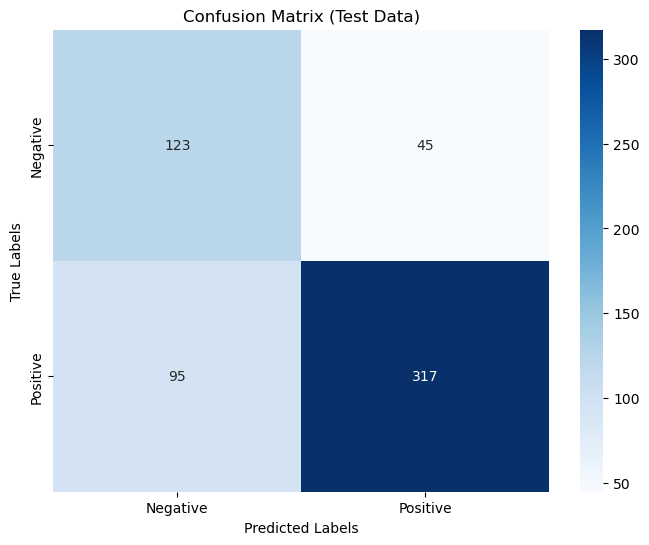

Accuracy: 0.7586206896551724
Precision: 0.8756906077348067
Recall: 0.7694174757281553
F1-Score: 0.8191214470284238
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.73      0.64       168
           1       0.88      0.77      0.82       412

    accuracy                           0.76       580
   macro avg       0.72      0.75      0.73       580
weighted avg       0.79      0.76      0.77       580



In [29]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate metrics
TP = np.sum((y_test == 1) & (y_pred == 1))
FP = np.sum((y_test == 0) & (y_pred == 1))
TN = np.sum((y_test == 0) & (y_pred == 0))
FN = np.sum((y_test == 1) & (y_pred == 0))

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Precision
precision = TP / (TP + FP)

# Recall (Sensitivity)
recall = TP / (TP + FN)

# F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Test Data)')
plt.show()

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

_Evaluate tuned model (After Hyperparameter Tuning) with worse scores on test set._

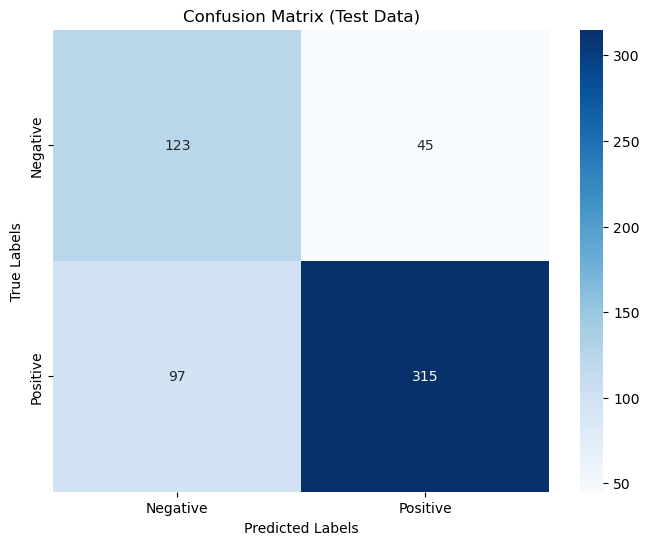

Accuracy: 0.7551724137931034
Precision: 0.875
Recall: 0.7645631067961165
F1-Score: 0.8160621761658031
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.73      0.63       168
           1       0.88      0.76      0.82       412

    accuracy                           0.76       580
   macro avg       0.72      0.75      0.73       580
weighted avg       0.78      0.76      0.76       580



In [30]:
# Make predictions on the test data
y_pred_tuned = model_tuned.predict(X_test)

# Calculate metrics
TP = np.sum((y_test == 1) & (y_pred_tuned == 1))
FP = np.sum((y_test == 0) & (y_pred_tuned == 1))
TN = np.sum((y_test == 0) & (y_pred_tuned == 0))
FN = np.sum((y_test == 1) & (y_pred_tuned == 0))

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Precision
precision = TP / (TP + FP)

# Recall (Sensitivity)
recall = TP / (TP + FN)

# F1-Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Test Data)')
plt.show()

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))